In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np

# import librosa
# from librosa import power_to_db

In [2]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    epsilon = 1e-10
    specgram_np = specgram.numpy() + epsilon
    # print(np.min(specgram_np), np.max(specgram_np))

    db = 10 * np.log10(specgram_np)
    ax.imshow(db, origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [3]:
path = 'Major_0.wav'
waveform, sample_rate = torchaudio.load(path, normalize=True)
print(waveform.shape)
print(sample_rate)
# apply fourier transform
transform = torchaudio.transforms.Spectrogram(n_fft=1024)
spectrogram = transform(waveform)
print(spectrogram.shape)

# generate a standard sine wave. dimension: 1 x 44100
std_waveform = torch.sin(torch.linspace(0, 50 * np.pi, 44100))
# add a dimension of channel
std_waveform = std_waveform.unsqueeze(0)
# apply fourier transform
std_spectrogram = transform(std_waveform)
print(std_waveform.shape)
print(std_spectrogram.shape)

# torch stft
std_stft = torch.stft(std_waveform, n_fft=1024, hop_length=512, return_complex=True)
print(std_stft.shape)



torch.Size([1, 99225])
44100
torch.Size([1, 513, 194])
torch.Size([1, 44100])
torch.Size([1, 513, 87])
torch.Size([1, 513, 87])


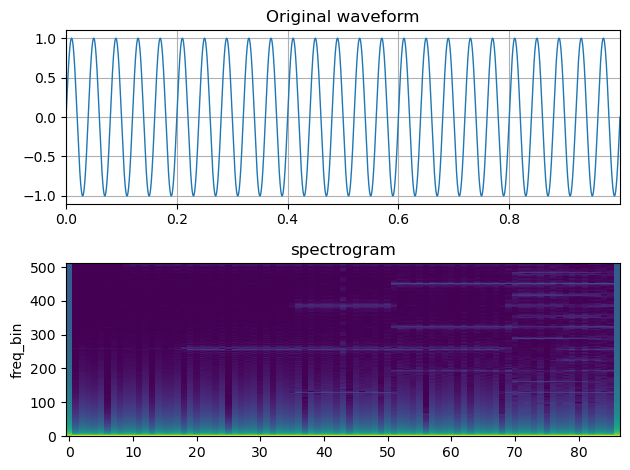

In [4]:
fig, axs = plt.subplots(2, 1)
plot_waveform(std_waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(std_spectrogram[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [5]:
for time_index in range(0, 80, 5):
    max_freq_index = std_spectrogram[0, :, time_index].argmax()
    print(max_freq_index)

tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


In [6]:
# Generate a standard waveform with unknown frequency
unknown_freq_waveform = torch.sin(torch.linspace(0, 2 * np.pi, 44100))

# Apply Fourier transform
transform = torchaudio.transforms.Spectrogram(n_fft=1024)
unknown_freq_spectrogram = transform(unknown_freq_waveform.unsqueeze(0))
print(unknown_freq_spectrogram.shape)
# Get the frequency with the maximum magnitude
max_freq_index = unknown_freq_spectrogram[0].argmax()
sample_rate = 44100
frequency = max_freq_index * (sample_rate / 2) / unknown_freq_spectrogram.shape[1]

print("Frequency:", frequency)
print("Correct!" if frequency == 1.0 else "Incorrect!")


torch.Size([1, 513, 87])
Frequency: tensor(2793.8596)
Incorrect!


[7092. 6211. 7091. 5447. 4567.  439.  441. 5448. 4568.  440.]
[1.39737974e-14 1.56419488e-14 1.57098911e-14 1.82576471e-14
 1.83295202e-14 1.87448777e-14 1.88986822e-14 2.38341874e-14
 2.39217540e-14 1.00000000e+00]


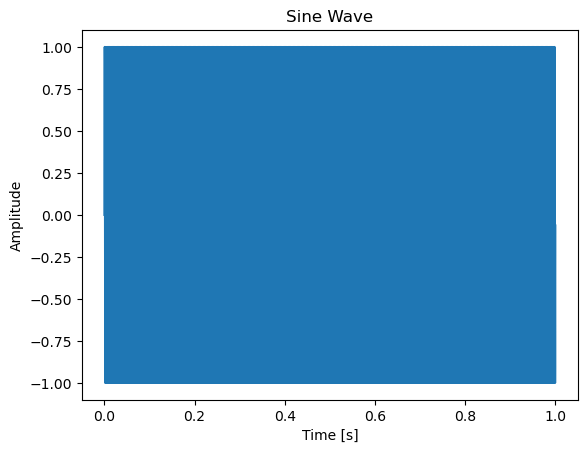

Approximated frequency: 440.0 Hz


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a standard sine wave with unknown frequency
def generate_sine_wave(duration, unknown_freq):
    sample_rate = 44100  # Sample rate in Hz
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    sine_wave = np.sin(2 * np.pi * unknown_freq * t)
    return t, sine_wave

# Approximate the frequency
def approximate_frequency(sine_wave, sample_rate):
    n = len(sine_wave)
    yf = np.fft.fft(sine_wave)
    xf = np.fft.fftfreq(n, 1 / sample_rate)
    freqs = xf[:n // 2]
    mag = 2.0 / n * np.abs(yf[:n // 2])
    approx_freq = freqs[np.argmax(mag)]
    # find 5 largest peaks
    idx = np.argsort(mag)
    idx = idx[-10:]
    print(freqs[idx])
    print(mag[idx])
    return approx_freq

# Generate the sine wave
duration = 1.0  # seconds
unknown_freq = 440.0  # Unknown frequency in Hz
t, sine_wave = generate_sine_wave(duration, unknown_freq)

# Approximate the frequency
sample_rate = 44100  # Sample rate in Hz
approx_freq = approximate_frequency(sine_wave, sample_rate)

# Plot the sine wave
plt.plot(t, sine_wave)
plt.title('Sine Wave')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

print(f"Approximated frequency: {approx_freq} Hz")

In [13]:
combination_wave = generate_sine_wave(duration, 440.0)[1] + generate_sine_wave(duration, 523.25)[1] + generate_sine_wave(duration, 659.25)[1]
approx_freq = approximate_frequency(combination_wave, sample_rate)

[659. 523. 440.]
[0.89862632 0.90193623 1.00233234]


In [19]:
path = 'Major_0.wav'
waveform, sample_rate = torchaudio.load(path, normalize=True)
print(waveform.shape)
print(sample_rate)
approx_freq = approximate_frequency(waveform[0].numpy(), sample_rate)
# [495.55555556 262.22222222 524.88888889 392.         330.22222222]
# B4 C4 C5 G4 E4
# major chord E4 is: E4 G#4 B4
# minor chord E4 is: E4 G4 B4   

torch.Size([1, 99225])
44100
[495.11111111 196.         588.44444444 130.66666667 261.77777778
 495.55555556 262.22222222 524.88888889 392.         330.22222222]
[0.03330694 0.03344913 0.03566775 0.03995594 0.04184012 0.04553046
 0.04610733 0.04952307 0.05060222 0.08181607]
